In [1]:
!file "/content/archive (1).zip"


/content/archive (1).zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [11]:
import zipfile
import os

# Path to your uploaded zip
zip_path = "/content/archive (1).zip"
extract_dir = "/content/Brain_Stroke_CT-SCAN_image_Split"

# ✅ Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset extracted to:", extract_dir)


✅ Dataset extracted to: /content/Brain_Stroke_CT-SCAN_image_Split


In [12]:
import os
import shutil

# ✅ Paths
base_path = "/content/Brain_Stroke_CT-SCAN_image_Split"
global_test_path = os.path.join(base_path, "global_test")

# 🧹 Remove old global_test if exists
if os.path.exists(global_test_path):
    shutil.rmtree(global_test_path)

# ✅ Create global_test/Normal and Stroke folders
os.makedirs(os.path.join(global_test_path, "Normal"))
os.makedirs(os.path.join(global_test_path, "Stroke"))

# ✅ How many samples to copy
samples_per_class_per_hospital = 20

# ✅ Copy samples from each hospital's Test/Normal and Test/Stroke
for hospital in ["Hospital_1", "Hospital_2", "Hospital_3"]:
    for class_label in ["Normal", "Stroke"]:
        source_dir = os.path.join(base_path, hospital, "Test", class_label)
        dest_dir = os.path.join(global_test_path, class_label)

        # Avoid crashing if folder is missing
        if os.path.exists(source_dir):
            files = os.listdir(source_dir)[:samples_per_class_per_hospital]
            for fname in files:
                shutil.copy(os.path.join(source_dir, fname), dest_dir)

print("✅ global_test directory created and populated.")


✅ global_test directory created and populated.


🧾 Normal samples: ['51 (26).jpg', '124 (24).jpg', '51 (10).jpg', '126 (17).jpg', '65 (11).jpg', '116 (1).jpg', '118 (13).jpg', '106 (10).jpg', '62 (8).jpg', '121 (21).jpg', '63 (5).jpg', '61 (12).jpg', '121 (3).jpg', '123 (32).jpg', '125 (36).jpg', '122 (11).jpg', '104 (17).jpg', '105 (12).jpg', '63 (33).jpg', '106 (21).jpg', '63 (34).jpg', '125 (37).jpg', '129 (2).jpg', '98 (19).jpg', '53 (26).jpg', '120 (18).jpg', '123 (18).jpg', '111 (18).jpg', '129 (26).jpg', '53 (28).jpg', '111 (6).jpg', '96 (11).jpg', '113 (24).jpg', '124 (5).jpg', '109 (7).jpg', '56 (27).jpg', '103 (12).jpg', '118 (3).jpg', '60 (8).jpg', '64 (19).jpg', '124 (10).jpg', '121 (8).jpg', '57 (27).jpg', '117 (21).jpg', '56 (2).jpg', '106 (7).jpg', '118 (14).jpg', '119 (3).jpg', '62 (20).jpg', '114 (18).jpg', '117 (22).jpg', '103 (1).jpg', '129 (3).jpg', '64 (3).jpg', '98 (3).jpg', '123 (34).jpg', '62 (6).jpg', '102 (29).jpg', '123 (17).jpg', '102 (7).jpg', '101 (19).jpg', '130 (9).jpg', '107 (22).jpg', '109 (8).jpg', 

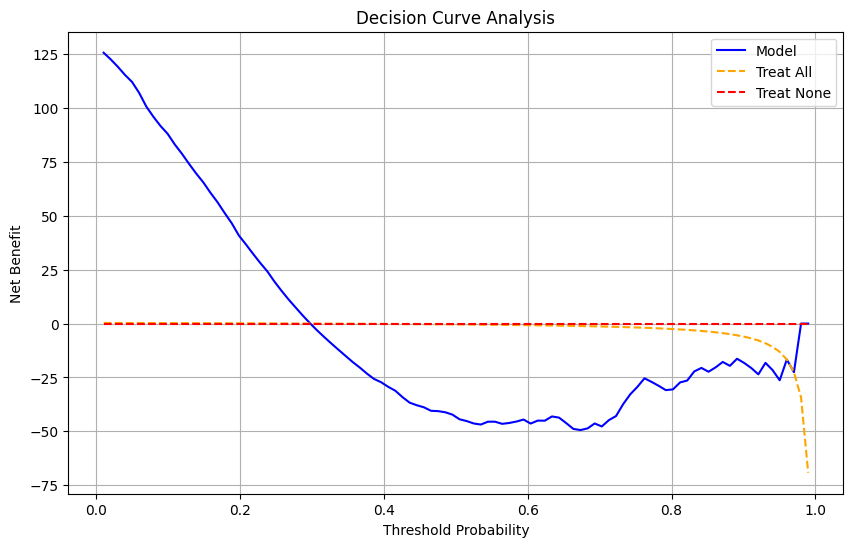

In [14]:
# 📦 Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# 📁 Set paths
# 📁 Set paths
global_test_path = "/content/Brain_Stroke_CT-SCAN_image_Split/Brain_Stroke_CT-SCAN_image/Test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


# ✅ Check if there are images
for class_dir in ["Normal", "Stroke"]:
    class_path = os.path.join(global_test_path, class_dir)
    print(f"🧾 {class_dir} samples:", os.listdir(class_path))

# ✅ Load dataset
global_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    global_test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)
global_test_ds = global_test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# 🧠 Build and load model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.load_weights("/content/best_global_model.weights.h5")

# 📈 Generate predictions
y_true = np.concatenate([y.numpy() for _, y in global_test_ds])
y_pred_probs = model.predict(global_test_ds).flatten()

# 📊 DCA function
def decision_curve(y_true, y_pred_probs, thresholds=np.linspace(0.01, 0.99, 100)):
    n = len(y_true)
    net_benefit = []

    for t in thresholds:
        y_pred = y_pred_probs >= t
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)

    treat_all = (np.sum(y_true == 1) / n) - (np.sum(y_true == 0) / n) * (thresholds / (1 - thresholds))
    treat_none = np.zeros_like(thresholds)

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, net_benefit, label="Model", color='blue')
    plt.plot(thresholds, treat_all, label="Treat All", linestyle="--", color='orange')
    plt.plot(thresholds, treat_none, label="Treat None", linestyle="--", color='red')
    plt.xlabel("Threshold Probability")
    plt.ylabel("Net Benefit")
    plt.title("Decision Curve Analysis")
    plt.legend()
    plt.grid(True)
    plt.show()

# 🧪 Evaluate
decision_curve(y_true, y_pred_probs)


🧾 Normal samples: ['51 (26).jpg', '124 (24).jpg', '51 (10).jpg', '126 (17).jpg', '65 (11).jpg']
🧾 Stroke samples: ['69 (36).jpg', '78 (15).jpg', '84 (16).jpg', '81 (37).jpg', '69 (5).jpg']
Found 437 files belonging to 2 classes.
✅ Model weights loaded.
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 777ms/step


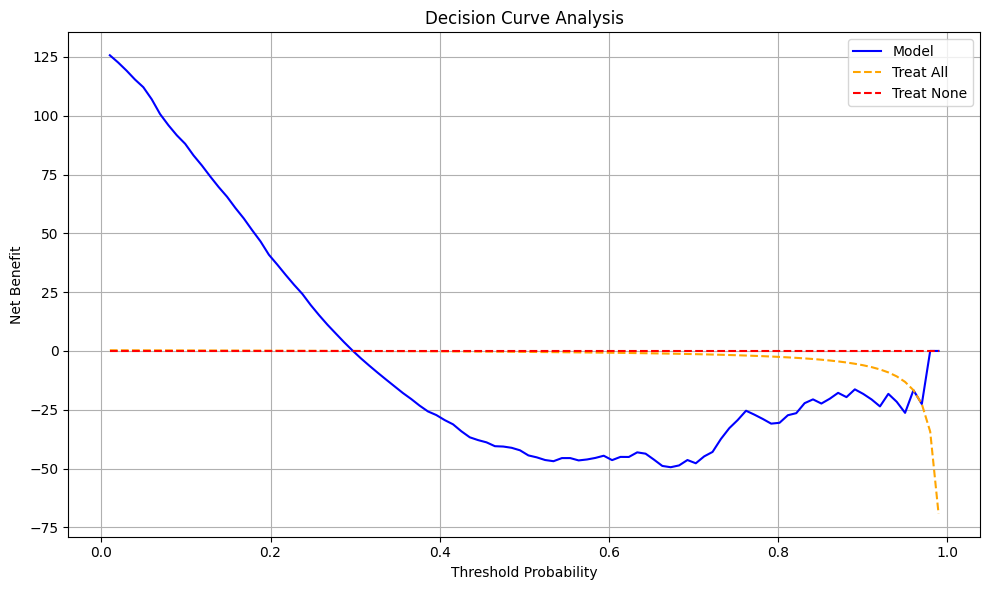

In [15]:
# 📦 Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 📁 Path Configuration
TEST_DIR = "/content/Brain_Stroke_CT-SCAN_image_Split/Brain_Stroke_CT-SCAN_image/Test"
MODEL_WEIGHTS = "/content/best_global_model.weights.h5"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Dataset Verification
for class_dir in ["Normal", "Stroke"]:
    class_path = os.path.join(TEST_DIR, class_dir)
    print(f"🧾 {class_dir} samples:", os.listdir(class_path)[:5])  # Show a few samples

# 🔄 Load Dataset
global_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)
global_test_ds = global_test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# 🧠 Build Model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 📥 Load Federated Weights
model = build_model()
model.load_weights(MODEL_WEIGHTS)
print("✅ Model weights loaded.")

# 🔍 Generate Predictions
y_true = np.concatenate([y.numpy() for _, y in global_test_ds])
y_pred_probs = model.predict(global_test_ds).flatten()

# 📈 Decision Curve Analysis Function
def decision_curve(y_true, y_pred_probs, thresholds=np.linspace(0.01, 0.99, 100)):
    n = len(y_true)
    net_benefit = []

    for t in thresholds:
        y_pred = y_pred_probs >= t
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)

    treat_all = (np.sum(y_true == 1) / n) - (np.sum(y_true == 0) / n) * (thresholds / (1 - thresholds))
    treat_none = np.zeros_like(thresholds)

    # 📊 Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, net_benefit, label="Model", color="blue")
    plt.plot(thresholds, treat_all, label="Treat All", linestyle="--", color="orange")
    plt.plot(thresholds, treat_none, label="Treat None", linestyle="--", color="red")
    plt.xlabel("Threshold Probability")
    plt.ylabel("Net Benefit")
    plt.title("Decision Curve Analysis")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dca_curve.png")  # 📁 Save the plot
    plt.show()

# 🧪 Run DCA
decision_curve(y_true, y_pred_probs)


In [16]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic -y
!jupyter nbconvert --to pdf /content/Notebook_10_DCA.ipynb --output dca_evaluation_report.pdf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

# 📘 Notebook 10: Decision Curve Analysis (DCA)

## 🎯 Objective
To evaluate the clinical usefulness of the global federated deep learning model using Decision Curve Analysis.

---

## 🧪 Dataset
- Source: `/content/Brain_Stroke_CT-SCAN_image_Split/Test`
- Classes: Normal, Stroke
- Format: 224x224 JPEG images
- Loaded via `image_dataset_from_directory`

---

## 🧠 Model
```python
Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Flatten → Dense(128) → Dense(1, sigmoid)
